## Part 3
Now go to the set of 29 images and repeat everything you did in Part 2 above for this larger dataset. 

In [53]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import glob
import os
import itertools

In [54]:
# Part 1 Functions
def normalize_images(imgs):
    imgs_norm = []
    for img in imgs:
        img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        imgs_norm.append(img_norm)
    return imgs_norm

def grayscale_images(imgs):
    imgs_gray = []
    for img in imgs:
        gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Apply CLAHE to grayscale images
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        imgs_gray.append(clahe.apply(gr))
    return imgs_gray

def find_features(sift_object, imgs_gray):
    kp = []
    des = []
    imgs_sift = []
    for img in imgs_gray:
        k, d = sift_object.detectAndCompute(img,None)
        img_sift = cv2.drawKeypoints(img, k, img, color=[255,255,0], flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        imgs_sift.append(img_sift)
        kp.append(np.array(k))
        des.append(np.array(d))
    return kp, des, imgs_sift

def get_matches(kp1, des1, kp2, des2):
    # FLANN parameters https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html 
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50) # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    flann_match = flann.knnMatch(des1,des2,k=2)
    # Need to draw only good matches, so create a mask
    good = []

    # ratio test as per Lowe's paper
    for m,n in flann_match:
        if m.distance < 0.7*n.distance:
            good.append(m)

    src_pts = np.array([kp1[m.queryIdx].pt for m in good])
    dst_pts = np.array([kp2[m.trainIdx].pt for m in good])

    return (src_pts, dst_pts)

def get_all_matches(kp, des):
    matches = []
    if len(kp) == 6:
        last_img_match = 0
    elif len(kp) == 28:
        last_img_match = 13
    else:
        print("Length of keypoints not expected")
        
    for i in range(len(kp)):
        ii = i+1 if i < len(kp)-1 else last_img_match
        matches.append(get_matches(kp[i], des[i], kp[ii], des[ii]))
        print("Image: ", i, ", ", ii, " Matches: ", len(matches[i][0]))

    return matches


def get_homography(kp_match_inliers):
    h = []
    pts_left_src = []
    pts_right_dst = []
    mask = []

    # if inliers were not already given to the homography function, get points and do RANSAC
    for kp_match in kp_match_inliers:
        pts_left_src.append(np.float32([kp_match[0][i] for i in range(len(kp_match[0]))]))
        pts_right_dst.append(np.float32([kp_match[1][i] for i in range(len(kp_match[1]))]))

    # this is only for the last run
    for i in range(len(pts_left_src)):
        h_img, mask_img = cv2.findHomography(pts_right_dst[i],pts_left_src[i],cv2.RANSAC,3.0)
        h.append(h_img)
        mask.append(mask_img)
    return h, mask, (pts_left_src, pts_right_dst)

def adjust_image_frame(H, src_shape, dst_shape):
    # Get corners of the source image
    (h, w) = src_shape
    img_corners = np.float32([[0, 0],
                            [w - 1, 0],
                            [w - 1, h - 1],
                            [0, h - 1]])
    
    # Convert to Array in Homogeneous Coordinates
    corners_base = np.array([img_corners[:, 0],
                            img_corners[:,1],
                            np.ones(4)])

    # Calculate distorted corner pixel coordinates by multiplying by Homography matrix
    corners_distorted = np.dot(H, corners_base)
    [x, y, c] = corners_distorted
    x = np.divide(x, c)
    y = np.divide(y, c)

    # Finding the dimentions of the distorted image frame
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))

    # Fit Right Side of Image
    w_stitched = max(max_x, dst_shape[1])
    h_stitched = max(max_y, dst_shape[0])

    # Add offset if distorted stitching goes out of current image frame
    offset = [0, 0]
    if min_x < 0:
        offset[0] = abs(min_x)
        w_stitched += offset[0]
    if min_y < 0:
        offset[1] = abs(min_y)
        h_stitched += offset[1]

    # Add offset to stitched corner coordinates
    corners_stitched = np.float32(np.array([x + offset[0], y + offset[1]]).transpose())

    # Recompute homography s.t. the source image is in frame
    H = cv2.getPerspectiveTransform(img_corners, corners_stitched)
    
    return [h_stitched, w_stitched], offset, H


def alpha_blending(img1, img2):
    # Blend images together
    black = np.zeros(img1.shape, dtype=np.uint8)
    mask_dst = cv2.inRange(img1, np.array([0,0,0]), np.array([0,0,0]))
    mask_src = cv2.inRange(img2, np.array([0,0,0]), np.array([0,0,0]))

    # Get the non-overlapping components of both images
    dst_fringe = cv2.bitwise_or(img1, img2, mask=mask_dst)
    src_fringe = cv2.bitwise_or(img1, img2, mask=mask_src)

    # Get the overlapping region and set it to white to use as a mask
    overlap_region = cv2.bitwise_and(
        cv2.bitwise_or(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), mask=cv2.bitwise_not(mask_dst)),
        cv2.bitwise_or(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), mask=cv2.bitwise_not(mask_src)))
    overlap_region[overlap_region>0.0] = 255

    # Blend only the overlapping regions of the image
    img_overlap_blend = cv2.addWeighted(
        cv2.bitwise_or(img2, black, mask=overlap_region), 0.5,
        cv2.bitwise_or(img1, black, mask=overlap_region), 0.5, 0.0)

    return dst_fringe + src_fringe + img_overlap_blend


def stitch_images(img_dst, img_src, H):
    # Finding size of new frame of stitched images and updating the homography matrix 
    stitched_dims, offset, H = adjust_image_frame(H, img_src.shape[:2], img_dst.shape[:2])
    # Finally placing the images upon one another.
    src_warped = cv2.warpPerspective(img_src, H, (stitched_dims[1], stitched_dims[0]))

    # Expand destimation image frame to fit source image
    dst_transformed = np.zeros((stitched_dims[0], stitched_dims[1], 3), dtype=np.uint8)
    dst_transformed[offset[1]:offset[1]+img_dst.shape[0], offset[0]:offset[0]+img_dst.shape[1]] = img_dst

    img_stitched = alpha_blending(dst_transformed, src_warped)

    return img_stitched, offset

def stitch_all_images(imgs, h):
    img_offset = [0,0]
    img_mosaic = imgs[0]
    h[-1] = np.identity(3) 

    if len(imgs) == 6:
        last_img_match = 0
    elif len(imgs) == 28:
        last_img_match = 13
    else:
        print("Length of keypoints not expected")

    for i in range(len(h)-1):
        h[i][0][2] += img_offset[0]
        h[i][1][2] += img_offset[1]
        h[i] = np.dot(h[i],h[i-1]) # h[-1] defined as identity for first homography
        
        ii = i+1 if i < len(imgs)-1 else last_img_match
        img_mosaic, img_offset = stitch_images(img_mosaic,imgs[ii],h[i])
    return img_mosaic

In [71]:
imgs = []
dir_name = '29images/'
list_of_files = sorted( filter( os.path.isfile, glob.glob(dir_name + '*') ) )
# Iterate over sorted list of images
for file_path in list_of_files:
    imgs.append(cv2.imread(file_path))

In [72]:
imgs_norm = normalize_images(imgs)
imgs_gray = grayscale_images(imgs_norm)
img_h, img_w = imgs_gray[0].shape

# Create SIFT Object and save keypoints, descriptors, and sift-labeled images
sift = cv2.SIFT_create(nfeatures=5000, nOctaveLayers=16, contrastThreshold=0.025, edgeThreshold=10, sigma=1.4)
kp, des, imgs_sift = find_features(sift, imgs_gray)

matches = get_all_matches(kp, des)

Image:  0 ,  1  Matches:  390
Image:  1 ,  2  Matches:  246
Image:  2 ,  3  Matches:  211
Image:  3 ,  4  Matches:  308
Image:  4 ,  5  Matches:  104
Image:  5 ,  6  Matches:  186
Image:  6 ,  7  Matches:  57
Image:  7 ,  8  Matches:  513
Image:  8 ,  9  Matches:  587
Image:  9 ,  10  Matches:  597
Image:  10 ,  11  Matches:  579
Image:  11 ,  12  Matches:  390
Image:  12 ,  13  Matches:  54
Image:  13 ,  14  Matches:  542
Image:  14 ,  15  Matches:  474
Image:  15 ,  16  Matches:  764
Image:  16 ,  17  Matches:  566
Image:  17 ,  18  Matches:  760
Image:  18 ,  19  Matches:  818
Image:  19 ,  20  Matches:  252
Image:  20 ,  21  Matches:  532
Image:  21 ,  22  Matches:  701
Image:  22 ,  23  Matches:  381
Image:  23 ,  24  Matches:  573
Image:  24 ,  25  Matches:  569
Image:  25 ,  26  Matches:  450
Image:  26 ,  27  Matches:  389
Image:  27 ,  13  Matches:  204


(-0.5, 1906.5, 1420.5, -0.5)

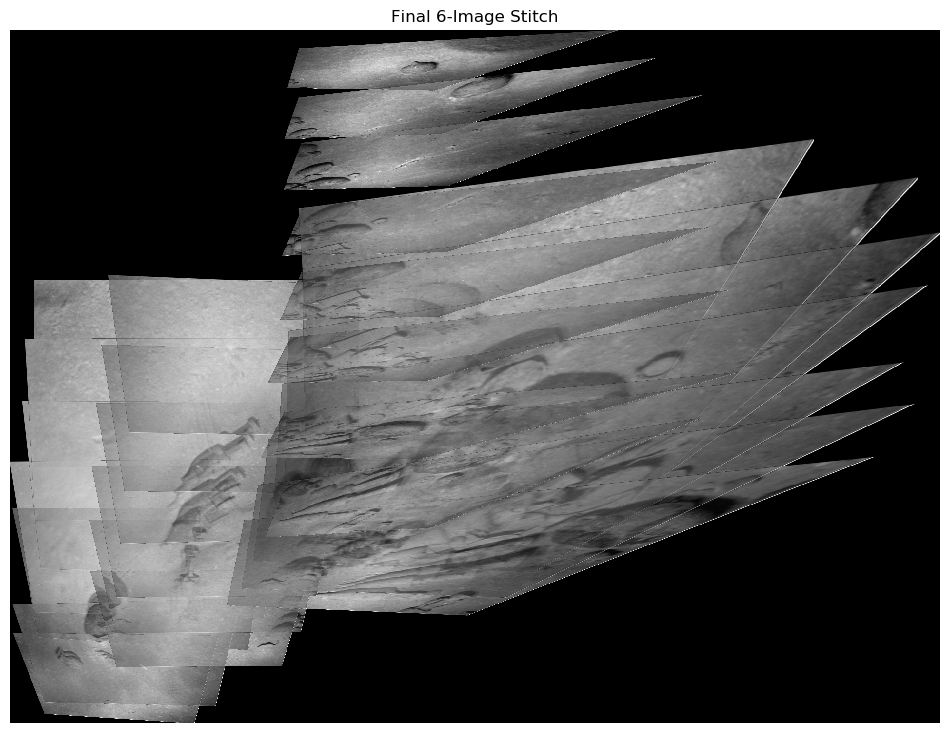

In [73]:
h, mask, pts_corr = get_homography(matches)

img_mosaic = stitch_all_images(imgs_norm, h)

plt.figure(figsize = (12,12))
plt.imshow(img_mosaic)
plt.title("Final 6-Image Stitch")
plt.axis('off')

In [74]:
#import g2o
import gtsam
import gtsam.utils.plot

Create a noise model for the covariance matrix.<br>
Set the covariance matrix as diagonal by using the number of matching points in each image. 

$ cov = \begin{bmatrix} x_{err} & 0 & 0 \\ 0 & y_{err} & 0 \\ 0 & 0 & \theta_{err} \end{bmatrix}$<br>

In [75]:
def noise_model(mask):
    numMatches = np.count_nonzero(mask)
    minError = [0.2, 0.2, 0.1]
    smallError = [0.5, 0.5, 0.25]
    largeError = [0.8, 0.8, 0.4]
    maxError = [1.0, 1.0, 0.5]
    
    if numMatches > 200:
        err = minError
    elif numMatches > 100 and numMatches <= 200:
        err = smallError
    elif numMatches > 50 and numMatches <= 100:
        err = largeError
    else:
        err = maxError
    
    return gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(err[0], err[1], err[2]))

Initialize the GTSAM graph

In [76]:
noise_init = gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(0.3, 0.3, 0.1))
graph = gtsam.NonlinearFactorGraph()

# add initial point at image origin (middle of a normalized image)
graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(img_w/2, img_h/2, 0), noise_init))

Get factor poses / observations between the images. <br>
Get the similarity matrix (partial affine matrix) between matching points and extract the X, Y, and $\theta$ from that matrix.

In [77]:
ransac_mask = []
def get_factor_pose(index, pts_src = pts_corr[0], pts_dst = pts_corr[1]):
    global ransac_mask

    similarity_mat, ransac_mask = cv2.estimateAffinePartial2D(pts_dst[index],pts_src[index])
    scale = np.sqrt(similarity_mat[0, 0]**2+similarity_mat[1, 0]**2)
    similarity_mat[:2, :2] /= scale
    affine_matrix = np.vstack((similarity_mat, [0, 0, 1]))

    return gtsam.Pose2(affine_matrix[0, -1], affine_matrix[1, -1],
                np.arctan2(affine_matrix[1, 0], affine_matrix[0, 0]))
        
get_factor_pose(0)

(-14.5011, 124.421, -0.00942782)

Get initial estimates to the solution using homographies from Part 1.

In [78]:
def extractHomographyPose(h):
   affineEst = h
   affineEst[2][0] = 0
   affineEst[2][1] = 0
   scale = np.sqrt(affineEst[0,0]**2+affineEst[1,0]**2)
   affineEst[:2, :2] /= scale
   rot = affineEst[:2, :2]
   total_affine_matrix = np.eye(3)

   affineEst_inv = np.linalg.inv(affineEst)
   affineEst = affineEst_inv.dot(total_affine_matrix)
   return gtsam.Pose2(affineEst[0, -1], affineEst[1, -1],
                  np.arctan2(affineEst[1, 0], affineEst[0, 0]))

def initialEstimates(h):
    initial_estimate = gtsam.Values()
    initial_estimate.insert(0, gtsam.Pose2())
    
    for i in range(len(h)-1):
        initial_estimate.insert(i+1, extractHomographyPose(h[i]))
        
    return initial_estimate

initial = initialEstimates(h)

In [79]:
def plot_graph(values, graph, marginals):

    for vertex_index in range(values.size()):
        gtsam.utils.plot.plot_pose2(0, values.atPose2(
            vertex_index), 0.5, marginals.marginalCovariance(vertex_index))

    for edge_index in range(graph.size())[1:]:
        key1, key2 = graph.at(edge_index).keys()

        start_pose = values.atPose2(key1)
        end_pose = values.atPose2(key2)
        plt.plot([start_pose.x(), end_pose.x()],
                 [start_pose.y(), end_pose.y()],
                 color='blue')

    plt.show()

Build the Graph by looping through all images and check for loop closures on non-successive images.

In [80]:
for src_index, dst_index in itertools.combinations(range(len(imgs_norm)), 2):
    if src_index + 1 == dst_index: # nonlinear graph initialization
        graph.add(gtsam.BetweenFactorPose2(
            src_index, 
            dst_index,
            get_factor_pose(src_index), 
            noise_model(mask[src_index])))
    
    else: # Find Loop Closures
        # NOTE: Need to change this to check only images immediately next to it
        kp_match_overlap = [get_matches(kp[src_index], des[src_index], kp[dst_index], des[dst_index])]
        
        print(len(kp_match_overlap[0][0])) # Printing overlaps
        if len(kp_match_overlap[0][0]) < 20: continue
        homog, maskIm, _ = get_homography(kp_match_overlap)

        pts_left_overlap = []
        pts_right_overlap = []
        for kp_matches in kp_match_overlap:
            pts_left_overlap.append(np.float32([kp_matches[0][i] for i in range(len(kp_matches[0]))]))
            pts_right_overlap.append(np.float32([kp_matches[1][i] for i in range(len(kp_matches[1]))]))

        factor_pose = get_factor_pose(0, pts_left_overlap, pts_right_overlap)
        if factor_pose is not None:
            graph.add(gtsam.BetweenFactorPose2(
                src_index, 
                dst_index,
                factor_pose, 
                noise_model(ransac_mask)))


79
1
4
5
4
6
2
1
2
16
80
1
1
6
3
4
2
4
1
1
5
4
4
1
2
4
26
5
2
3
10
2
5
11
70
136
8
5
7
5
2
4
8
2
6
4
6
4
4
3
8
62
13
2
19
10
55
102
169
74
7
3
14
12
5
10
5
4
3
6
6
5
2
9
12
14
3
16
30
134
150
93
10
5
9
9
5
9
17
7
5
3
9
11
9
4
7
8
11
40
86
192
117
60
4
8
7
5
4
4
4
8
5
5
6
6
8
4
3
5
127
93
27
5
14
8
5
7
8
14
5
7
2
4
4
6
5
4
3
6
9
16
1
1
2
7
5
2
7
4
2
8
2
2
1
6
6
7
2
2
5
106
10
3
2
4
1
8
2
9
23
32
4
8
7
6
6
4
4
1
140
7
5
5
3
7
7
27
26
26
6
6
3
3
2
6
4
4
146
5
9
7
21
46
33
18
15
12
8
7
7
11
9
4
7
100
2
13
51
42
20
5
5
5
2
4
5
6
6
7
6
8
29
24
25
7
6
10
5
8
5
1
3
2
2
10
59
13
4
6
5
6
2
2
4
6
1
4
5
2
93
4
1
2
2
1
3
2
2
6
55
163
205
156
2
5
2
6
1
3
19
110
264
230
73
133
5
6
5
5
18
141
380
276
88
6
45
2
7
6
55
322
434
163
14
8
195
16
134
272
291
157
27
14
6
133
354
369
76
13
3
11
8
382
196
14
11
9
10
8
99
6
6
5
8
3
58
10
3
9
7
62
9
6
7
142
5
6
103
4
58


Plot graph before Loop Closures

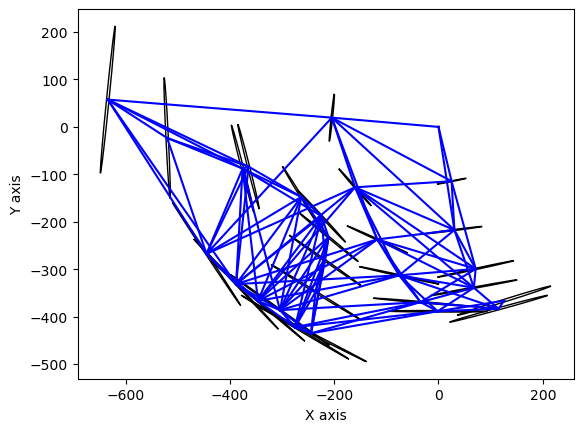

In [81]:
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

Plot graph using Levenberg Marquardt Optimization and Loop Closure

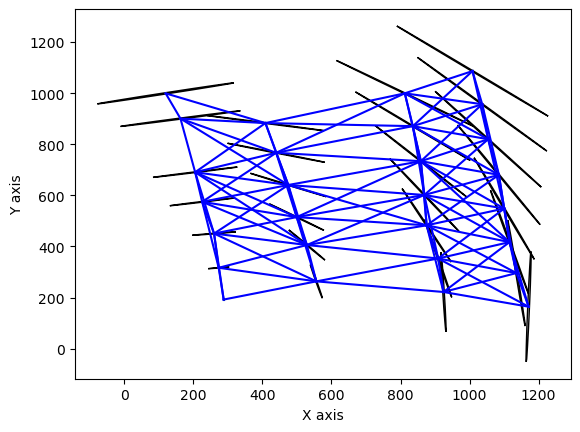

In [82]:
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
initial = optimizer.optimize()
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

Get the final optimized affine matrices from the factor graph above

In [83]:
def get_optimized_affine_matrix(initial, image_list):
    poses = gtsam.utilities.allPose2s(initial)
    affine_matrix_list = []

    for index in range(len(image_list)):
        pose = poses.atPose2(index)
        affine_matrix = pose.matrix()
        translation_matrix = np.eye(3)
        translation_matrix[:2, 2] -= np.array([img_w/2, img_h/2]).T
        affine_matrix_list.append(affine_matrix.dot(translation_matrix))
    
    affine_matrix_list.reverse()
    return affine_matrix_list

In [84]:
affine_matrix_list = get_optimized_affine_matrix(initial, imgs_norm)

# TEST MY METHOD OF STITCHING 

In [85]:
def get_warp_point(homography_matrix, point):
    warp_point = homography_matrix.dot(np.append(point, [1]).T)
    return (warp_point / warp_point[-1])[:2]

In [86]:
def get_stitch_image_size_offset_affine_matrix(homography_matrix_list):
    corner_point_list = []

    for homography_matrix in homography_matrix_list:

        corner_point_list.append(get_warp_point(
            homography_matrix, [0, 0]))
        corner_point_list.append(get_warp_point(
            homography_matrix, [img_w - 1, 0]))
        corner_point_list.append(get_warp_point(
            homography_matrix, [img_w - 1, img_h - 1]))
        corner_point_list.append(get_warp_point(
            homography_matrix, [0, img_h - 1]))

    min_point = (np.floor(np.amin(corner_point_list, axis=0))).astype(np.int32)
    max_point = (np.ceil(np.amax(corner_point_list, axis=0))).astype(np.int32)

    stitch_image_size = tuple(max_point - min_point + 1)

    offset_affine_matrix = np.eye(3, dtype=np.float64)
    if min_point[0] < 0:
        offset_affine_matrix[0, -1] -= min_point[0]
    if min_point[1] < 0:
        offset_affine_matrix[1, -1] -= min_point[1]
    return stitch_image_size, offset_affine_matrix

In [87]:
def get_stitch_image(homography_matrix_list, image_list, stitch_image_size, offset_affine_matrix):

    stitch_image = np.zeros(
        (stitch_image_size[1], stitch_image_size[0], 3), np.uint8)
    print(stitch_image.shape)
    image_list.reverse()
    for homography_matrix, image in zip(homography_matrix_list, image_list):
        
        warp_image = cv2.warpPerspective(
            image, offset_affine_matrix.dot(homography_matrix), stitch_image_size)
        #plt.imshow(warp_image)
        #break
        warp_image_mask = (warp_image != 0)
        stitch_image[warp_image_mask] = warp_image[warp_image_mask]
        
        
        output = alpha_blending(stitch_image,warp_image)
    

    return output

In [88]:
print(len(affine_matrix_list))
print(len(imgs_norm))
print(h[0])
print(affine_matrix_list[0])

28
28
[[ 9.99981684e-01  5.63721157e-02 -1.86537482e+01]
 [-6.05248500e-03  1.04959528e+00  1.20346163e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.90720770e-01 -1.35913048e-01  9.11641623e+02]
 [ 1.35913048e-01  9.90720770e-01 -6.53272437e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


(1377, 1666, 3)


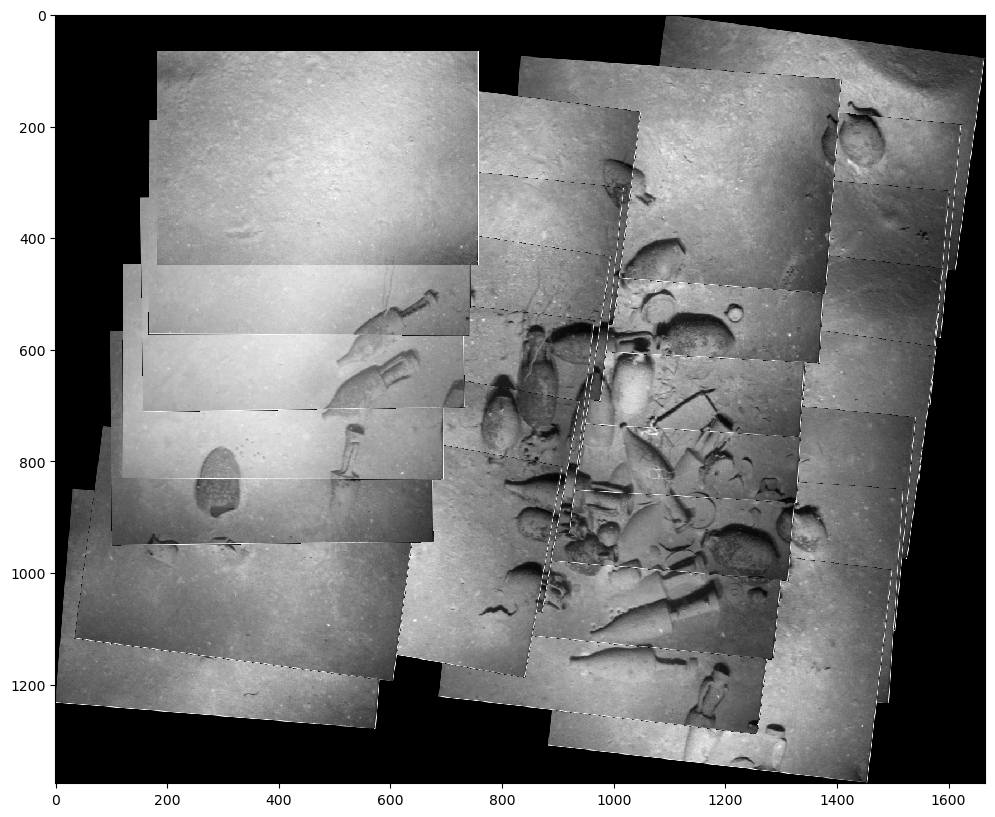

In [91]:
stitch_image_size, offset_affine_matrix = get_stitch_image_size_offset_affine_matrix(
    affine_matrix_list)

stitch_image = get_stitch_image(
    affine_matrix_list, imgs_norm, stitch_image_size, offset_affine_matrix)

plt.figure(figsize = (12,12))
plt.imshow(stitch_image)
plt.show()

(1666, 1377)
3
(384, 576)
[457, 1481]
[0, 65]
[[ 9.90720821e-01 -1.35913016e-01  9.11641602e+02]
 [ 1.35913057e-01  9.90720756e-01 -3.27243686e-01]
 [ 5.09469707e-11  6.98920985e-12  1.00000000e+00]]
(1377, 1666, 3)


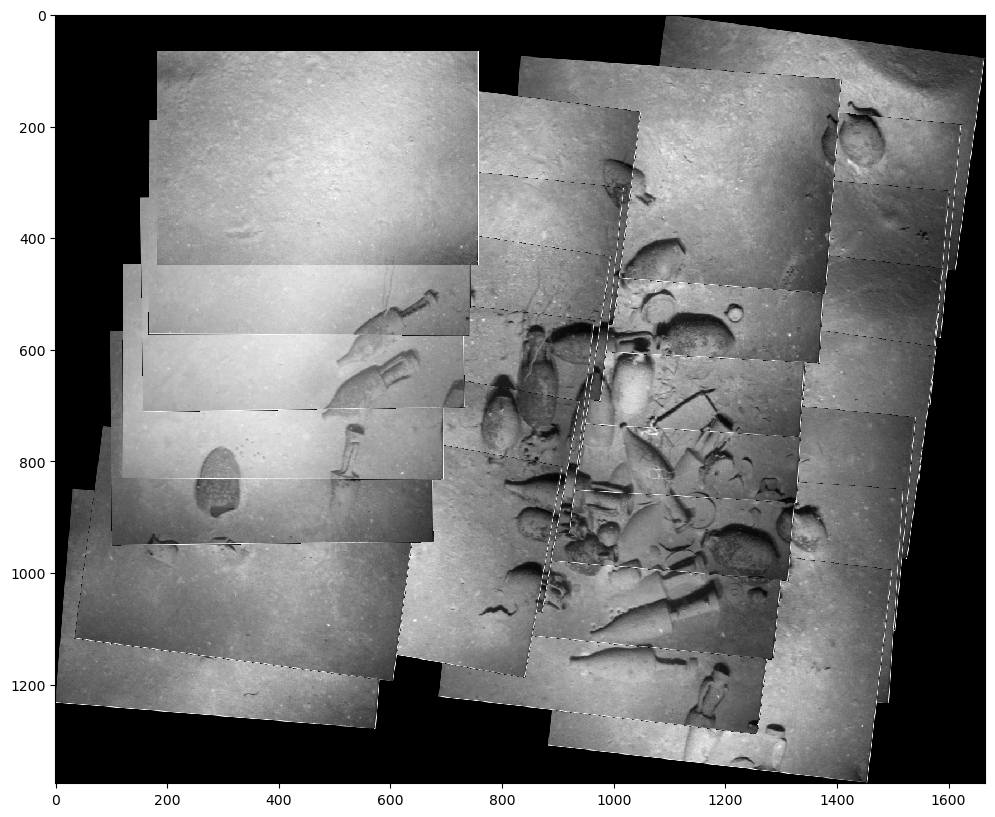

In [93]:
stitch_image_size1, offset_affine_matrix = get_stitch_image_size_offset_affine_matrix(
    affine_matrix_list)

print(stitch_image_size1)
print(len(offset_affine_matrix))
    
print(imgs_norm[0].shape[:2])
a, b, c = adjust_image_frame(affine_matrix_list[0], imgs_norm[0].shape[:2], imgs_norm[0].shape[:2])
print(a)
print(b)
print(c)

stitch_image1 = get_stitch_image(
    affine_matrix_list, imgs_norm, stitch_image_size1, offset_affine_matrix)

plt.figure(figsize = (12,12))
plt.imshow(stitch_image1)
plt.show()

In [69]:
h = affine_matrix_list

img_new = stitch_all_images(imgs_norm,h)
    


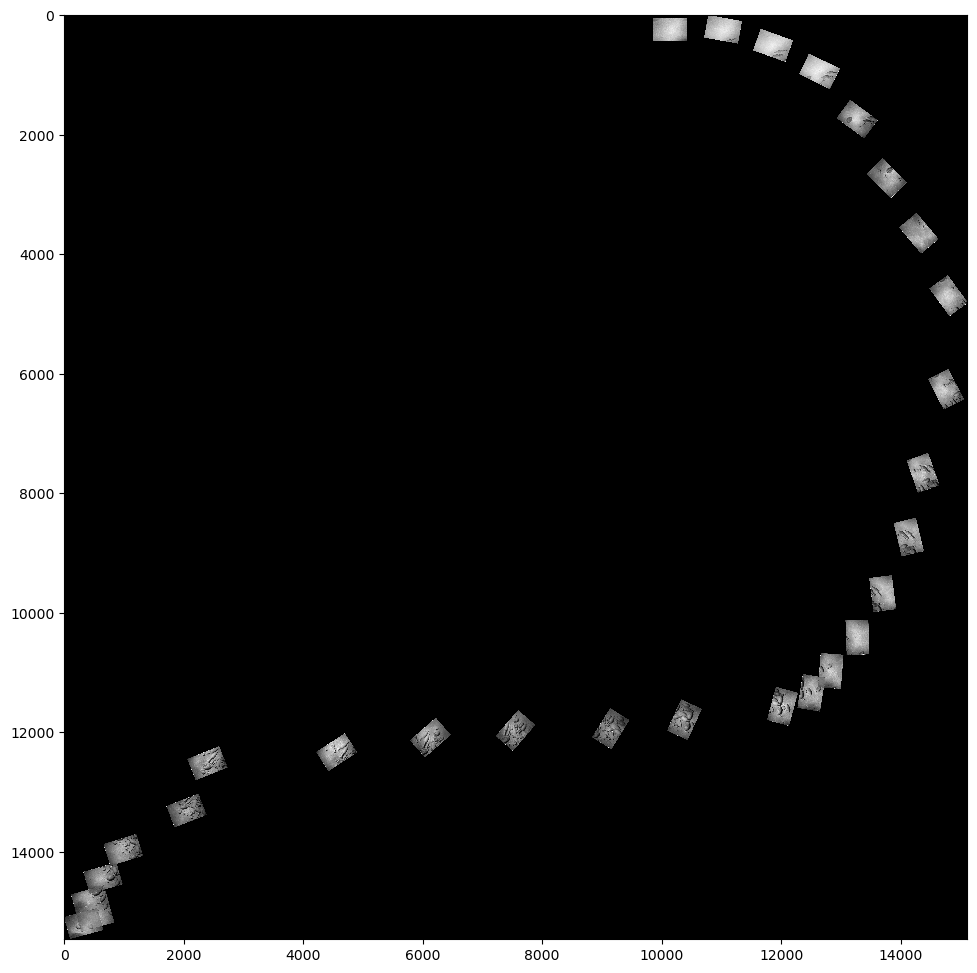

In [70]:
plt.figure(figsize = (12,12))
plt.imshow(img_new)
plt.show()